In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import time
from torch.utils.data import DataLoader
from case118.dataset import Dataset

device = 'cpu'
s = 1

In [2]:
alt_x = np.load('../nets/net_18_data/measured_data_x_alt.npy')
alt_y = np.load('../nets/net_18_data/data_y_alt.npy')
data_x = alt_x
data_y = alt_y

split_train = int(0.8 * data_x.shape[0])
train_x = data_x[:split_train, :]
train_y = data_y[:split_train, :]

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=42)

train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.3, shuffle=True, random_state=42)


val_data = Dataset(val_x, val_y)
val_dataloader = DataLoader(val_data, batch_size=int(len(val_data) / s), drop_last=False)

test_data = Dataset(test_x, test_y)
# test_dataloader = DataLoader(test_data, batch_size=100, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data))


In [3]:
num_input = 53
num_output = 18

in_columns = [str(i) for i in range(num_input)]
out_columns = [str(i) for i in range(num_input, num_input + num_output)]

In [4]:
from case118.networks import ANN

model = ANN(num_input, 1524, num_output, dropout=0.4656649267466235)
model.load_state_dict(torch.load("model_net18_53.pth"))
model.eval()
model = model.to(device)

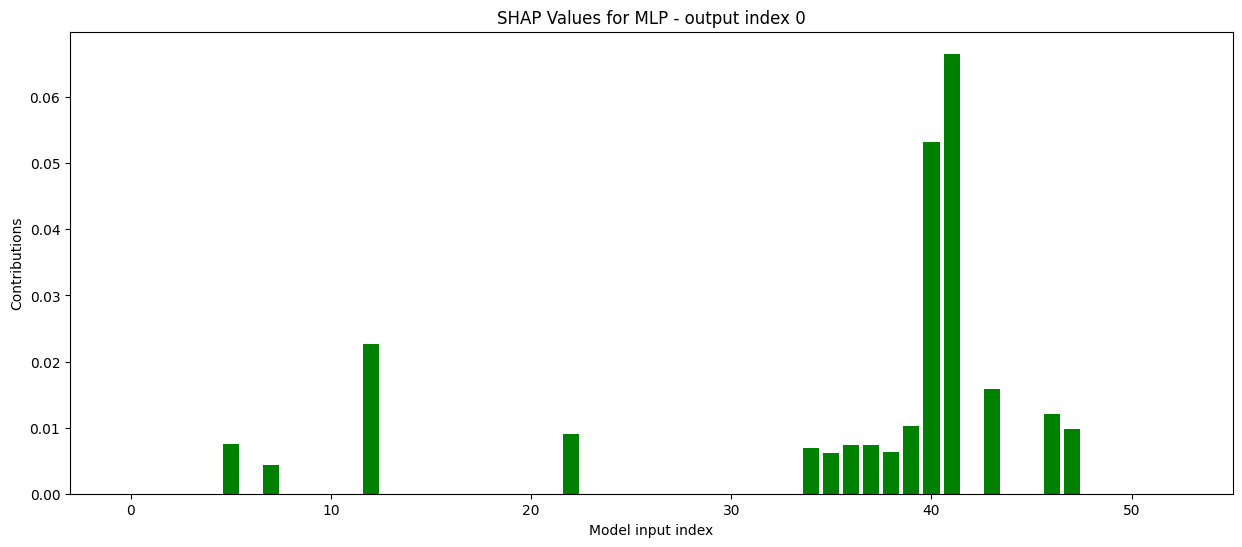

'\nnorm_relevance = ((relevance-abs(relevance)) / (max(relevance) - min(relevance)))\n\nprint(relevance)\nplt.imshow(norm_relevance.reshape((53, 1)))\nplt.colorbar()\n'

In [8]:
import shap

import matplotlib.pyplot as plt

np.random.seed(42)
node_index = 0
columns_names = in_columns + out_columns

def wrapped_model(x):
    test_data = Dataset(x, np.zeros((len(x), 18)))
    test_dataloader = DataLoader(test_data, batch_size=len(test_data))

    with torch.no_grad():
        for batch, (X, _) in enumerate(test_dataloader):
            X, _ = X.to(device), _
            pred = model(X)
            pred = pred.cpu().detach().numpy()
    return pred

to_be_explained = test_x[0]
random_indices = np.random.choice(test_x.shape[0], size=100, replace=False)
explainer = shap.KernelExplainer(wrapped_model, train_x[random_indices])
shap_values = explainer.shap_values(to_be_explained)
relevance = abs(shap_values[node_index].ravel())

x_positions = np.arange(len(relevance))
plt.figure(figsize=(15,6))
plt.bar(x_positions, relevance, color='green')
plt.xlabel('Model input index')
plt.ylabel('Contributions')
plt.title(f'SHAP Values for MLP - output index {node_index}')

plt.show()

'''
norm_relevance = ((relevance-abs(relevance)) / (max(relevance) - min(relevance)))

print(relevance)
plt.imshow(norm_relevance.reshape((53, 1)))
plt.colorbar()
'''

In [17]:
import lime.lime_tabular
import matplotlib.pyplot as plt

np.random.seed(42)

node_index = 0
columns_names = in_columns + out_columns
predictor = model

def wrapped_model(x):
    test_data = Dataset(x, np.zeros((len(x), 18)))
    test_dataloader = DataLoader(test_data, batch_size=len(test_data))

    with torch.no_grad():
        for batch, (X, _) in enumerate(test_dataloader):
            X, _ = X.to(device), _
            pred = model(X)
            pred = pred.cpu().detach().numpy()
    return pred[:, node_index]

to_be_explained = test_x[0]
random_indices = np.random.choice(test_x.shape[0], size=100, replace=False)
background = train_x[random_indices]
explainer = lime.lime_tabular.LimeTabularExplainer(
    background,
    feature_names=columns_names[:-1],
    verbose=True,
    mode='regression'
)

exp = explainer.explain_instance(to_be_explained, wrapped_model, num_features=53)
relevance = abs(np.asarray([j for i,j in sorted(exp.local_exp[1], key=lambda i: i[0])]))

x_positions = np.arange(len(relevance))
plt.figure(figsize=(15,6))
plt.bar(x_positions, relevance, color='green')
plt.xlabel('Model input index')
plt.ylabel('Contributions')
plt.title(f'LIME for MLP - output index {node_index}')
#plt.xticks(x_positions, ['A', 'B', 'C', 'D', 'E'])

plt.show()

Intercept 1.3098351846840768
Prediction_local [1.48234724]
Right: 1.0332918


KeyboardInterrupt: 

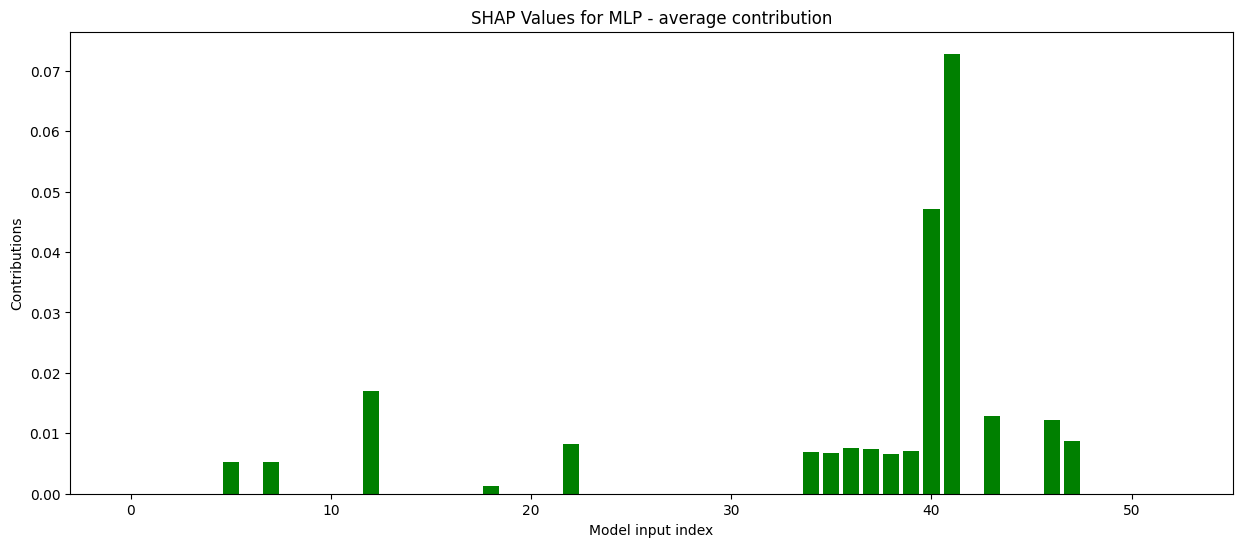

'\nnorm_relevance = ((relevance-abs(relevance)) / (max(relevance) - min(relevance)))\n\nprint(relevance)\nplt.imshow(norm_relevance.reshape((53, 1)))\nplt.colorbar()\n'

In [7]:
import shap

import matplotlib.pyplot as plt

np.random.seed(42)
columns_names = in_columns + out_columns

def wrapped_model(x):
    test_data = Dataset(x, np.zeros((len(x), 18)))
    test_dataloader = DataLoader(test_data, batch_size=len(test_data))

    with torch.no_grad():
        for batch, (X, _) in enumerate(test_dataloader):
            X, _ = X.to(device), _
            pred = model(X)
            pred = pred.cpu().detach().numpy()
    return pred

to_be_explained = test_x[0]
random_indices = np.random.choice(test_x.shape[0], size=100, replace=False)
explainer = shap.KernelExplainer(wrapped_model, train_x[random_indices])
shap_values = explainer.shap_values(to_be_explained)
relevance = abs(np.asarray(shap_values)).mean(axis=0).ravel()

x_positions = np.arange(len(relevance))
plt.figure(figsize=(15,6))
plt.bar(x_positions, relevance, color='green')
plt.xlabel('Model input index')
plt.ylabel('Contributions')
plt.title(f'SHAP Values for MLP - average contribution')

plt.show()

'''
norm_relevance = ((relevance-abs(relevance)) / (max(relevance) - min(relevance)))

print(relevance)
plt.imshow(norm_relevance.reshape((53, 1)))
plt.colorbar()
'''

Intercept 1.3098351846840768
Prediction_local [1.48234724]
Right: 1.0332918
Intercept 1.3017031487195545
Prediction_local [1.47955733]
Right: 1.0407789
Intercept 1.330051071351322
Prediction_local [1.46963553]
Right: 1.0485772
Intercept 1.3253889881312677
Prediction_local [1.43692781]
Right: 1.0486283
Intercept 1.3106817205197252
Prediction_local [1.49429091]
Right: 1.0512676
Intercept 1.299313470013961
Prediction_local [1.54049217]
Right: 1.0514313
Intercept 1.3096952021586288
Prediction_local [1.51094362]
Right: 1.0515796
Intercept 1.3168373907844408
Prediction_local [1.44104878]
Right: 1.052104
Intercept 1.3016827701750997
Prediction_local [1.50070299]
Right: 1.0529795
Intercept 1.3281485309321692
Prediction_local [1.43956251]
Right: 1.0530177
Intercept 1.3217260840407739
Prediction_local [1.47039802]
Right: 1.0537829
Intercept 1.3208227148884384
Prediction_local [1.45037239]
Right: 1.0537694
Intercept 1.301292746714384
Prediction_local [1.58340047]
Right: 1.0678924
Intercept 1.3397

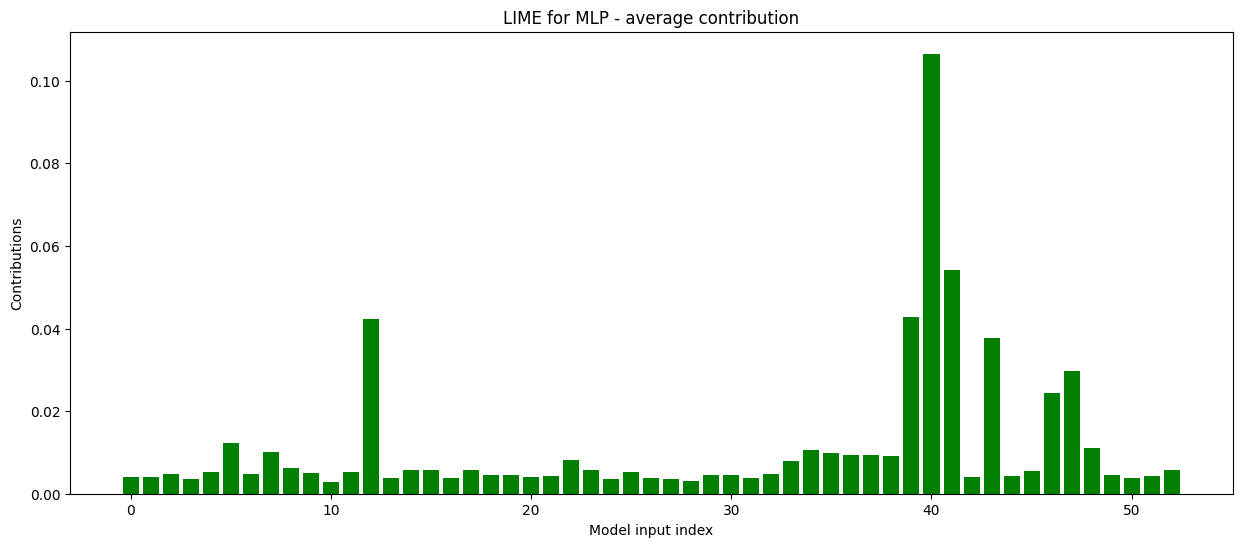

In [19]:
import lime.lime_tabular
import matplotlib.pyplot as plt

np.random.seed(42)

lime_values_total = []

columns_names = in_columns + out_columns
predictor = model

to_be_explained = test_x[0]
random_indices = np.random.choice(test_x.shape[0], size=100, replace=False)
background = train_x[random_indices]
explainer = lime.lime_tabular.LimeTabularExplainer(
    background,
    feature_names=columns_names[:-1],
    verbose=True,
    mode='regression'
)


for i in range(num_output):
    def wrapped_model(x):
        test_data = Dataset(x, np.zeros((len(x), 18)))
        test_dataloader = DataLoader(test_data, batch_size=len(test_data))
    
        with torch.no_grad():
            for batch, (X, _) in enumerate(test_dataloader):
                X, _ = X.to(device), _
                pred = model(X)
                pred = pred.cpu().detach().numpy()
        return pred[:, i]
    exp = explainer.explain_instance(to_be_explained, wrapped_model, num_features=53)
    lime_values = abs(np.asarray([j for i,j in sorted(exp.local_exp[1], key=lambda i: i[0])]))
    lime_values_total.append([abs(lime_values.ravel())])

relevance = np.asarray(lime_values_total).mean(axis=0).ravel()


x_positions = np.arange(len(relevance))
plt.figure(figsize=(15,6))
plt.bar(x_positions, relevance, color='green')
plt.xlabel('Model input index')
plt.ylabel('Contributions')
plt.title(f'LIME for MLP - average contribution')
#plt.xticks(x_positions, ['A', 'B', 'C', 'D', 'E'])

plt.show()